### Описание проекта

Оператор мобильной связи "Мегалайн" выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, спсобную проанализировать поведение клиентов и предложить пользователям новый тариф: "Смарт" и "Ультра".

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
import seaborn as sns

### Изучение данных из файла

In [3]:
df = pd.read_csv('users_behavior.csv')

In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Согласно документации к данным:

- calls — количество звонков, 
- minutes — суммарная длительность звонков в минутах,
- messages — количесвто сообщений,
- mb_used —	израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца ("Ультра" — 1, "Смарт" — 0)

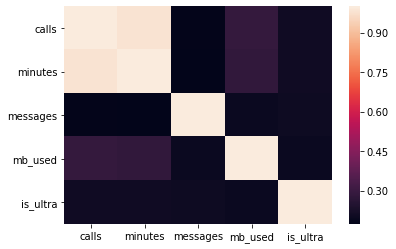

In [6]:
# Построение тепловой карты признаков
sns.heatmap(df.corr())

По построенной тепловой карте признаков видно, что параметры `calls` и `minutes` имеют сильную взаимозависимость, что может привести к переобучаемости модели. Исключим признак `calls`:

In [7]:
df = df.drop(columns='calls', axis=1)

# Обновленный датафрейм
df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


### Разделение на обучающую, тестовую и валидационную выборки

Разделим исходный датафрейм в соотношении: 

- обучающая выборка — 60%
- тестовая выборка — 20%
- валидационная выборка — 20%

In [8]:
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=12345)

In [9]:
df_test, df_valid = train_test_split(df_temp, test_size=0.5, random_state=12345)

Разделение данных на признаки и целевой признак для каждой выборки:

In [10]:
# Обучающая выборка
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']
print("Размер features_train:", features_train.shape, "\nРазмер target_train:", target_train.shape)

# Валидационная выборка
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']
print("\nРазмер features_valid:", features_valid.shape, "\nРазмер target_valid:", target_valid.shape)

# Тестовая выборка
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']
print("\nРазмер features_test:", features_test.shape, "\nРазмер target_test:", target_test.shape)

Размер features_train: (1928, 3) 
Размер target_train: (1928,)

Размер features_valid: (643, 3) 
Размер target_valid: (643,)

Размер features_test: (643, 3) 
Размер target_test: (643,)


### Создание и обучение модели

#### Решающее дерево

In [11]:
best_model = None
best_result = 0

for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    
    if result > best_result:
        best_result = result
        best_model = model
print("Accuracy модели решающего дерева на валидационной выборке:", best_result)
print("максимальная глубина решающего дерева", depth)

Accuracy модели решающего дерева на валидационной выборке: 0.7884914463452566
максимальная глубина решающего дерева 5


#### Случайный лес

In [12]:
best_model = None
best_result = 0

for est in range(1, 10):
    model = RandomForestClassifier(n_estimators=est, random_state=12345)
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    
    if result > best_result:
        best_result = result
        best_model = model
print("Accuracy модели случайный лес на валидационной выборке:", best_result)
print("количество деревьев", est)

Accuracy модели случайный лес на валидационной выборке: 0.7838258164852255
количество деревьев 9


#### Логистическая регрессия

In [13]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
    
predictions = model.predict(features_valid)
result = model.score(features_valid, target_valid)
print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.6982892690513219


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Вывод**

Доля правильных ответов на валидационной выобрке больше всего показала модель решающего дерева.

Проверим качество модели на тестовой выборке.

### Проверка качества модели на тестовой выборке 

In [14]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_train, target_train)

predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)
print("Accuracy модели решающего дерева на тестовой выборке:", result)

Accuracy модели решающего дерева на тестовой выборке: 0.7884914463452566


In [15]:
model = RandomForestClassifier(n_estimators=9, random_state=12345)
model.fit(features_train, target_train)

predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)
print("Accuracy модели случайный лес на тестовой выборке:", result)

Accuracy модели случайный лес на тестовой выборке: 0.7511664074650077


In [16]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
    
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)
print("Accuracy модели логистической регрессии на тестовой выборке:", result)

Accuracy модели логистической регрессии на тестовой выборке: 0.7076205287713841


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Вывод**

На валидационной выборке наилучшее значение **`accuracy`** показала модель решающего дерева. На тестовой выборке наилучшее значение также у модели решающего дерева.

### Проверка модели на адекватность

Сравнение полученной модели с константной моделью. 

Посчитаем долю правильных ответов на тестовой выборке, с предсказанным значением — наиболее частотным классом тарифа.

In [17]:
# Представители какого класса наиболее часто встречаются в выборке
print("Смарт", target_train[target_train == 0].count())
print("Ультра", target_train[target_train == 1].count())

Смарт 1335
Ультра 593


Наиболее частый ответ — "Смарт".

In [18]:
# Формируем массив предсказанных значений
predict  = pd.Series(0, index=target_test.index)

In [19]:
result = accuracy_score(target_test, predict)
print("Accuracy константной модели:", result)

Accuracy константной модели: 0.7060653188180405


**Вывод**

Доля правильных ответов высокая, модель предсказывает адекватно.

### Общий вывод

Для компании "Мегалайн" было проведено исследование поведения пользователей, для рекомендации более подходящего тарифа: "Смарт" или "Ультра".

Для решения задачи классификации были построены модели предсказания, из которых по доле правильных ответов выбиралась лучшая: модель решающего дерева, с гиперпараметрами `max_depth = 5` и `accuracy = 0.79`.